## NN Adv Assignment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/tobigs/Data/nn_adv_train.csv')
test = pd.read_csv('/content/drive/MyDrive/tobigs/Data/nn_adv_test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train['label'].nunique()

10

In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

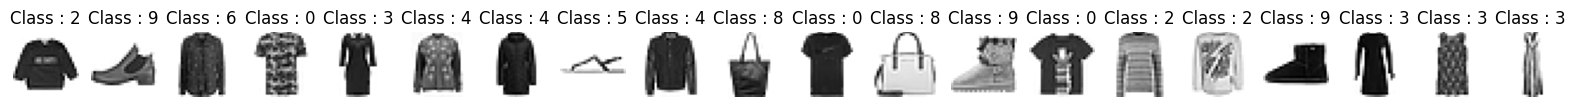

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [ ]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

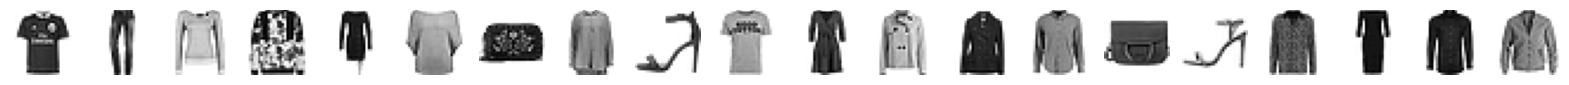

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [ ]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 64
#Epoch는 고정해주세요.
EPOCHS = 15

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [ ]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  scheduler.step()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [ ]:
X_train.shape

torch.Size([48000, 784])

In [ ]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 10)

        self.act_func = nn.LeakyReLU(negative_slope=0.01)

        self.bn1 = torch.nn.BatchNorm1d(256)
        self.bn2 = torch.nn.BatchNorm1d(128)

        #torch.nn.init.xavier_uniform_(self.layer1.weight)
        #torch.nn.init.xavier_uniform_(self.layer2.weight)
        #torch.nn.init.xavier_uniform_(self.layer3.weight)

        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_func(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_func(x)

        x = self.layer3(x)

        return x

model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.5142, 	Train Accuracy: 82.81 %, 	Val Loss: 0.3973, 	Val Accuracy: 85.67 % 

[EPOCH: 2], 	Train Loss: 0.3419, 	Train Accuracy: 87.66 %, 	Val Loss: 0.3853, 	Val Accuracy: 85.76 % 

[EPOCH: 3], 	Train Loss: 0.3015, 	Train Accuracy: 89.11 %, 	Val Loss: 0.3349, 	Val Accuracy: 87.83 % 

[EPOCH: 4], 	Train Loss: 0.2767, 	Train Accuracy: 89.80 %, 	Val Loss: 0.3551, 	Val Accuracy: 86.72 % 

[EPOCH: 5], 	Train Loss: 0.2486, 	Train Accuracy: 90.86 %, 	Val Loss: 0.3424, 	Val Accuracy: 87.24 % 

[EPOCH: 6], 	Train Loss: 0.2265, 	Train Accuracy: 91.56 %, 	Val Loss: 0.3225, 	Val Accuracy: 88.28 % 

[EPOCH: 7], 	Train Loss: 0.2107, 	Train Accuracy: 92.29 %, 	Val Loss: 0.3178, 	Val Accuracy: 88.53 % 

[EPOCH: 8], 	Train Loss: 0.1920, 	Train Accuracy: 92.95 %, 	Val Loss: 0.3702, 	Val Accuracy: 87.38 % 

[EPOCH: 9], 	Train Loss: 0.1781, 	Train Accuracy: 93.66 %, 	Val Loss: 0.3461, 	Val Accuracy: 87.62 % 

[EPOCH: 10], 	Train Loss: 0.1631, 	Train Accuracy: 94.10 %, 	Val Loss: 0.

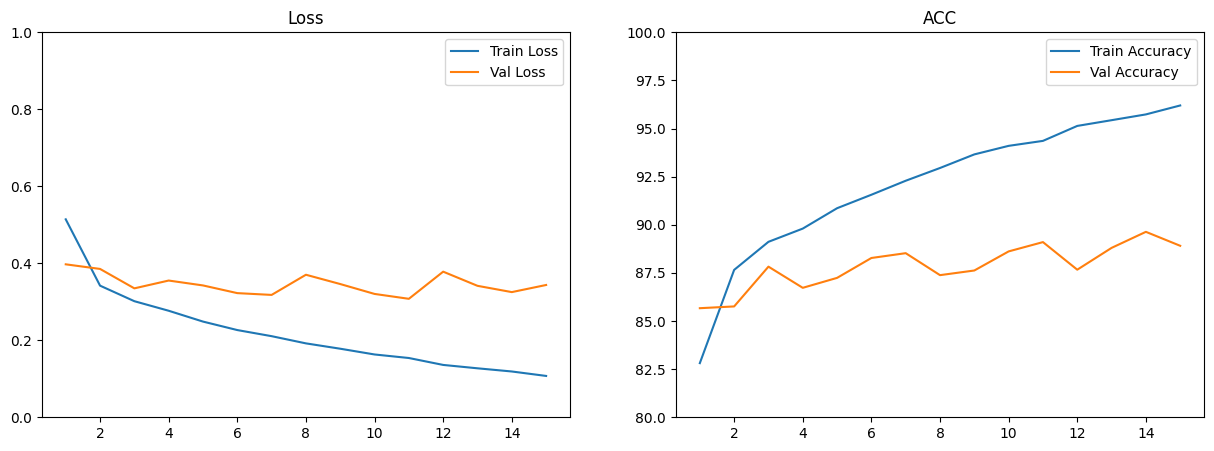

In [ ]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
1. Optimization: Scheduler, Adam
- 초기의 learning rate를 epoch에 따라 감소시키는 LambdaLR를 활용하였습니다.
  epoch 수가 제한되어있기 때문에 큰 learning rate를 설정하여 빠르게 minima로 접근하고자 하였으며,
  학습 후반에는 learning rate를 작게 함으로써 exploding이 발생하지 않도록 하였습니다.

- 딥러닝 분야에서 일반적으로 많이 활용하는 Adam Optimizer를 활용하였습니다.

2. Regularization: L2 Norm
- 가중치의 값이 커지지 않도록 조절하는 L2 Regularization을 활용하여 Over Fitting을 방지하고자 하였습니다.
  train loss는 급격하게 떨어지지만 valid loss는 일정 수준 이하로 떨어지지 않는 점을 발견하여
  해당 방법론을 사용하게 되었습니다.

3. Intialization
- 여러 Intialization 방법론을 사용하고자 하였으나, 실제 성능이 좋지 못했습니다.
  또한, torch에서 nn.Linear 를 선언하면 자동으로 Intialization이 수행된 weights를
  반환해준다고 하여, 따로 사용하지 않았습니다.

4. Normalization
- 일반적으로 많이 사용되는 Batch Normalization을 사용하였습니다.
  약간의 성능 개선이 있었습니다.
'''